In [28]:
import numpy as np
import random
from functools import reduce
import matplotlib.pyplot as plt
n_qubits = 10
n_layers=1
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Rotation gate around Y-axis
def RY(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ])

#Tensor product 
def kron_n(*ops):
    return reduce(np.kron, ops)
#initial state |000...0⟩
def initial_state(n):
    state = np.zeros(2**n, dtype=complex)
    state[0] = 1.0
    return state
#Construct full CNOT
def get_cnot_matrix(n_qubits, control, target):
    P0 = np.array([[1, 0], [0, 0]])  # |0⟩⟨0|
    P1 = np.array([[0, 0], [0, 1]])  # |1⟩⟨1|
    
    ops_0 = []
    ops_1 = []
    
    for i in range(n_qubits):
        if i == control:
            ops_0.append(P0)
            ops_1.append(P1)
        elif i == target:
            ops_0.append(I)
            ops_1.append(X)
        else:
            ops_0.append(I)
            ops_1.append(I)
    
    term1 = kron_n(*ops_0)
    term2 = kron_n(*ops_1)
    return term1 + term2
#Apply single-qubit gate
def apply_single_qubit_gate(state, gate, target, n_qubits):
    ops = [I] * n_qubits
    ops[target] = gate
    U = kron_n(*ops)
    return U @ state
#Applying CNOT
def apply_cnot(state, control, target, n_qubits):
    U_cnot = get_cnot_matrix(n_qubits, control, target)
    return U_cnot @ state
def hamiltonian(n_qubits, edges, seed):
    np.random.seed(seed)
    weights = np.random.uniform(0.2, 0.8, len(edges))
    
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)

    for (idx, (i, j)) in enumerate(edges):
        ops = [I] * n_qubits
        ops[i] = Z
        ops[j] = Z
        term = weights[idx] * kron_n(*ops)
        H += term

    return H, weights
def print_symbolic_hamiltonian(edges, weights):
    print("H = ", end="")
    terms = []
    for (i, j), w in zip(edges, weights):
        terms.append(f"{w:.3f} * Z[{i}]Z[{j}]")
    print(" + ".join(terms))
def ansatz(theta, n_qubits, edges, n_layers):
    state = initial_state(n_qubits)
    param_idx = 0

    for _ in range(n_layers):
        # Apply RY rotation to each qubit
        for i in range(n_qubits):
            angle = theta[param_idx]
            param_idx += 1
            ry_gate = RY(angle)
            state = apply_single_qubit_gate(state, ry_gate, i, n_qubits)

        # Apply CNOTs based on Hamiltonian structure
        for control, target in edges:
            state = apply_cnot(state, control, target, n_qubits)
    state = state / np.linalg.norm(state)
    return state

def generate_random_edges(n_qubits, n_edges, seed):
    random.seed(seed)
    all_possible_edges = [(i, j) for i in range(n_qubits) for j in range(i + 1, n_qubits)]
    edges = random.sample(all_possible_edges, min(n_edges, len(all_possible_edges)))
    return edges




In [29]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_qubit_connectivity(n_qubits, edges,seed):
    G = nx.Graph()
    G.add_nodes_from(range(n_qubits))
    G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed)  # Force-directed layout
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color='gray', width=2)
    plt.title("Qubit Connectivity Graph (Based on Hamiltonian Edges)")
    plt.show()



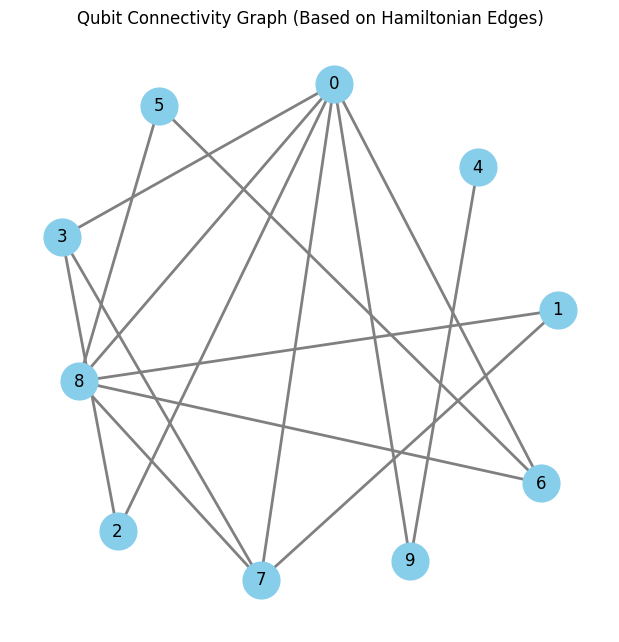

In [30]:
n_qubits = 10
n_edges = 15
seed = 42   
n_layers = 3
pdim=n_layers*n_qubits
edges = generate_random_edges(n_qubits, n_edges, seed)
visualize_qubit_connectivity(n_qubits, edges,seed)


In [31]:
def expectation(theta, H, n_qubits, n_layers):
    psi = ansatz(theta, n_qubits,edges, n_layers)
    return np.real(np.vdot(psi, H @ psi))
H, weights = hamiltonian(n_qubits, edges, seed)
print_symbolic_hamiltonian(edges, weights)
def cost(theta):
    return expectation(theta, H, n_qubits,n_layers)


H = 0.425 * Z[6]Z[8] + 0.770 * Z[0]Z[8] + 0.639 * Z[0]Z[2] + 0.559 * Z[2]Z[3] + 0.294 * Z[1]Z[8] + 0.294 * Z[1]Z[7] + 0.235 * Z[0]Z[9] + 0.720 * Z[0]Z[7] + 0.561 * Z[4]Z[9] + 0.625 * Z[0]Z[6] + 0.212 * Z[3]Z[7] + 0.782 * Z[0]Z[3] + 0.699 * Z[7]Z[8] + 0.327 * Z[5]Z[6] + 0.309 * Z[5]Z[8]


In [21]:
#Optimising using Nelder-Mead algorithm
def nelder_mead(f, x_start, step=0.5, tol=1e-3, max_iter=300):
    n = len(x_start)
    # Initialize simplex
    f_history = []
    simplex = [x_start]
    for i in range(n):
        x = np.array(x_start, dtype=float)
        x[i] += step
        simplex.append(x)
    simplex = np.array(simplex)
    #$print(simplex)
    for iteration in range(max_iter):
        # Sort simplex points by function value
        simplex = sorted(simplex, key=f)
        f_values = [f(x) for x in simplex]

        # Check convergence
        if np.std(f_values) < tol:
            break

        # Compute centroid (excluding worst point)
        centroid = np.mean(simplex[:-1], axis=0)

        # Reflection
        xr = centroid + (centroid - simplex[-1])
        fr = f(xr)

        if f_values[0] <= fr < f_values[-2]:
            simplex[-1] = xr
        elif fr < f_values[0]:
            # Expansion
            xe = centroid + 2 * (xr - centroid)
            fe = f(xe)
            simplex[-1] = xe if fe < fr else xr
        else:
            # Contraction
            xc1 = simplex[-1] + 0.25 * (xr-simplex[-1] )   
            xc3 = simplex[-1] + 0.75 * (xr-simplex[-1] )
            fc1 = f(xc1)
            fc3 = f(xc3)
            xc = 0
            fc = 0
            if fc1 < fc3:
                xc,fc= xc1,fc1
            else:
                xc,fc = xc3,fc3
            if fc < f_values[-1]:
                simplex[-1] = xc1
            else:
                # Shrink
                for i in range(1, len(simplex)):
                    simplex[i] = simplex[0] + 0.5 * (simplex[i] - simplex[0])
        print("function value at iteration", iteration, ":", f_values[0])
        f_history.append(f_values[0])
    best = min(simplex, key=f)
    return best, f(best), iteration + 1,f_history


x0 = np.random.uniform(0, 2 * np.pi,pdim)  # Initial guess
solnm, fval, iters,fhisto = nelder_mead(cost, x0)
print("[Nelder-Mead] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", fval)
print("[Nelder-Mead] Optimal θ:", solnm)
print("[Nelder-Mead] Iterations:", iters)


function value at iteration 0 : -0.9158650841241778
function value at iteration 1 : -1.3398412150823413
function value at iteration 2 : -1.3398412150823413
function value at iteration 3 : -1.3398412150823413
function value at iteration 4 : -1.3398412150823413
function value at iteration 5 : -1.3398412150823413
function value at iteration 6 : -1.3398412150823413
function value at iteration 7 : -1.3398412150823413
function value at iteration 8 : -1.3398412150823413
function value at iteration 9 : -1.3398412150823413
function value at iteration 10 : -1.3398412150823413
function value at iteration 11 : -1.3398412150823413
function value at iteration 12 : -1.3398412150823413
function value at iteration 13 : -1.3398412150823413
function value at iteration 14 : -1.3398412150823413
function value at iteration 15 : -1.3398412150823413
function value at iteration 16 : -1.3398412150823413
function value at iteration 17 : -1.3398412150823413
function value at iteration 18 : -1.3398412150823413
fun

In [32]:
solnm=[-0.08938711,  6.27841613,  3.61967964 , 5.45214702  ,2.60483152,  2.96652559,
  5.49225281 , 4.12046013 , 4.60938895 , 1.50939361 , 3.18352155 , 1.20058185,
  1.80334895  ,0.19478045 , 0.39023002 , 6.10076785 , 1.10232559 , 4.32753839,
  6.04238583  ,3.78961675 , 0.01191129 , 4.25113429 , 4.13909189 , 4.22131661,
  6.0169749   ,6.11460887  ,3.50478159 , 1.88454074  ,4.72258388 , 0.8841664 ]

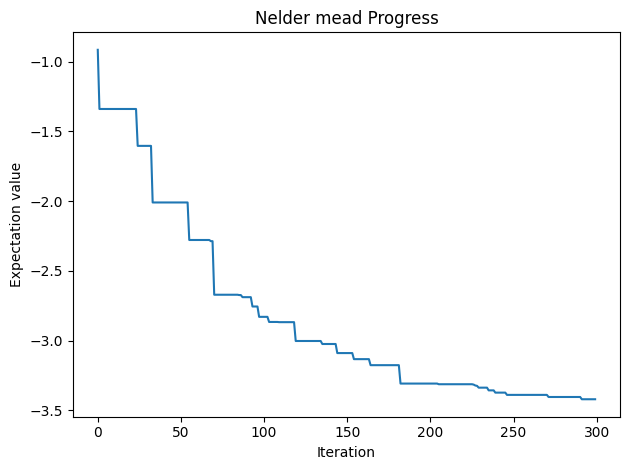

In [41]:
plt.plot(fhisto)
plt.xlabel('Iteration')
plt.ylabel('Expectation value')
plt.title('Nelder mead Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [16]:
# Optimising using SPSA algorithm
a = 0.7
c = 0.1
A = 80
alpha = 0.602
gamma = 0.101
f_history = []

# Initial point
#theta =np.random.uniform(0, 3*np.pi, size=(n_layers*n_qubits))
theta=np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)
max_iterations = 1000
tolerance = 1e-6
np.random.seed(42)

for k in range(max_iterations):
    ak = a / (A + k + 1)**alpha
    ck = c / (k + 1)**gamma
    delta = np.random.choice([-1, 1], size=pdim)  #perturbation vector Δ_k from Bernoulli(±1)
    theta_plus = theta + ck * delta
    theta_minus = theta - ck * delta
    y_plus = cost(theta_plus)
    y_minus = cost(theta_minus)
    g_hat = (y_plus - y_minus) / (2 * ck) * (1.0 / delta)
    theta = theta - ak * g_hat
    f_val = cost(theta)
    f_history.append(f_val)
    if k > 1 and abs(f_history[-1] - f_history[-2]) < tolerance and abs(f_history[-2] - f_history[-3]) < tolerance:
        break
print("[SPSA] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", f_val)
print("[SPSA] Optimal θ:", theta)
solspsa = theta
print("[SPSA] Iterations:", len(f_history))
print(f_history)


[SPSA] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -3.438907852033894
[SPSA] Optimal θ: [-2.04283913e-03  3.06028427e+00  1.90057663e+00  1.74993973e+00
  5.17194284e-01  6.55872038e+00  3.44812602e+00  1.59678452e+00
  1.57612447e+00  2.57267867e+00  3.06939258e+00  3.77676744e+00
  6.10556942e+00  3.24251189e+00  5.30734556e+00  5.32097276e+00
  1.13412197e+00  6.19581956e+00 -1.07924684e-02  4.80947634e+00
  6.12039958e-02  5.67390469e+00  4.55818831e+00  4.54221469e+00
  4.15571327e+00  2.05960034e+00  1.28388317e+00  1.90592329e+00
  1.55703604e+00  4.02384135e+00]
[SPSA] Iterations: 325
[0.3699190197791894, 0.36785193113066794, 0.3307807685360564, 0.33007234663822704, 0.1693782224892228, 0.16621686682002534, 0.11983407698854398, 0.08475668231537875, 0.08388617042245788, 0.07046182656469638, 0.024844598671231122, 0.012171699337353237, -0.005848385362368896, -0.010937717406134917, -0.03133055717843444, -0.047679311706584404, -0.07784688450057946, -0.08273178975113589, -0.11194697351741792, -0.203

In [33]:
solspsa=[-2.04283913e-03,  3.06028427e+00 , 1.90057663e+00 , 1.74993973e+00,
  5.17194284e-01 , 6.55872038e+00  ,3.44812602e+00 , 1.59678452e+00,
  1.57612447e+00 , 2.57267867e+00 , 3.06939258e+00 , 3.77676744e+00,
  6.10556942e+00  ,3.24251189e+00 , 5.30734556e+00 , 5.32097276e+00,
  1.13412197e+00  ,6.19581956e+00 ,-1.07924684e-02 , 4.80947634e+00,
  6.12039958e-02  ,5.67390469e+00 , 4.55818831e+00 , 4.54221469e+00,
  4.15571327e+00 , 2.05960034e+00 , 1.28388317e+00  ,1.90592329e+00,
  1.55703604e+00  ,4.02384135e+00]

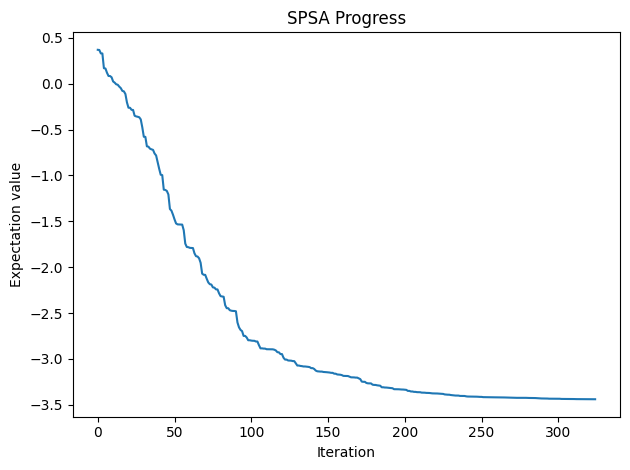

In [17]:
plt.plot(f_history)
plt.xlabel('Iteration')
plt.ylabel('Expectation value')
plt.title('SPSA Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [8]:
#Optimising using L-BFGS algorithm
def lbfgs(f, grad_f, x0, m=100, tol=1e-6, max_iter=1000):
    x = x0.copy()
    k = 0  # iteration counter
    s_list = []   
    y_list = []   
    rho_list = [] 
    g = grad_f(x)
    f_histry = []
    BOUND = 0  # number of updates used
    while np.linalg.norm(g) > tol and k < max_iter:
        q = g.copy()
        alpha = []
        if k < m:
            INCR = 0
            BOUND = k
        else:
            INCR = k - m
            BOUND = m
        for i in range(BOUND - 1, -1, -1):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            alpha_i = rho * np.dot(s, q)
            alpha.append(alpha_i)
            q = q - alpha_i * y

        alpha = alpha[::-1]  # to use in forward loop later

        if len(y_list) > 0:
            y_last = y_list[-1]
            s_last = s_list[-1]
            gamma = np.dot(s_last, y_last) / np.dot(y_last, y_last)
        else:
            gamma = 1.0
        r = gamma * q
        for i in range(0, BOUND):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            beta = rho * np.dot(y, r)
            r = r + s * (alpha[i] - beta)

        #search direction and backtracking line search
        p = -r
        t = 1.0
        while f(x + t * p) > f(x) + 1e-4 * t * np.dot(g, p):
            t *= 0.5
            if t < 1e-10:
                break
        #position and gradient update
        x_new = x + t * p
        g_new = grad_f(x_new)
        s_k = x_new - x
        y_k = g_new - g

        #store s_k, y_k, and ρ_k if curvature condition satisfied
        if np.dot(s_k, y_k) > 1e-10:
            s_list.append(s_k)
            y_list.append(y_k)
            rho_list.append(1.0 / np.dot(y_k, s_k))

            #maintaining memory size
            if len(s_list) > m:
                s_list.pop(0)
                y_list.pop(0)
                rho_list.pop(0)

        x = x_new
        g = g_new
        k += 1
        f_histry.append(f(x))
        #print(f"Iter {k:2d} | f(x) = {f(x):.6f} | ||grad|| = {np.linalg.norm(g):.2e}") 
    return x, f(x), k , f_histry


In [9]:
#writing a function grad that calculates gradient numerically 
def grad_numerical(func, v, h=1e-3):
    grad = np.zeros_like(v)
    for i in range(len(v)):
        v_plus = np.copy(v)
        v_minus = np.copy(v)
        v_plus[i] += h
        v_minus[i] -= h
        grad[i] = (func(v_plus) - func(v_minus)) / (2 * h)
    return grad

In [10]:
x0 =np.random.uniform(0, 2 * np.pi, pdim)  # Initial guess
solbfgs,fvalue,niter ,fhist= lbfgs(cost , lambda x: grad_numerical(cost, x), x0)
print("[L-BFGS] Optimal θ: ",solbfgs) 
print("[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: ",fvalue)
print("[L-BFGS] Iterations:", niter)
print(fhist)

[L-BFGS] Optimal θ:  [ 3.14159251e+00  6.76472858e+00  1.23961061e-07  8.13834457e-01
  4.82474118e+00  3.16692088e+00  2.46052766e+00 -5.26888415e-01
  1.57079628e+00  4.59696353e+00 -6.65561989e-08  3.14159358e+00
  2.71930035e-07  3.14159057e+00  1.92622219e-01  3.12844976e+00
  5.39510244e-01  3.14159290e+00  3.14159200e+00  3.11947364e+00
  6.28318521e+00  5.80164286e+00  3.14159277e+00  2.32775713e+00
  1.49179553e+00  3.12171703e+00  6.42486938e+00  3.66848100e+00
  4.71238857e+00  4.82744384e+00]
[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:  -3.6596101690327494
[L-BFGS] Iterations: 53
[-1.1893655882564604, -1.394137170204292, -1.8205176280968016, -2.1634324438118644, -2.365102850910895, -2.8922414664499656, -3.225768933215045, -3.3135400138904614, -3.349682695724643, -3.3837072060469975, -3.4064823453503505, -3.4308515998784888, -3.46143990862663, -3.483625726583974, -3.525525246990048, -3.5511216552657086, -3.585135538424168, -3.612145732338791, -3.6167686914453, -3.637888659528039, 

In [34]:
solbfgs=[ 3.14159251e+00,  6.76472858e+00 , 1.23961061e-07 , 8.13834457e-01,
  4.82474118e+00  ,3.16692088e+00  ,2.46052766e+00 ,-5.26888415e-01,
  1.57079628e+00 , 4.59696353e+00, -6.65561989e-08 , 3.14159358e+00,
  2.71930035e-07 , 3.14159057e+00,  1.92622219e-01 , 3.12844976e+00,
  5.39510244e-01 , 3.14159290e+00 , 3.14159200e+00 , 3.11947364e+00,
  6.28318521e+00 , 5.80164286e+00 , 3.14159277e+00 , 2.32775713e+00,
  1.49179553e+00 , 3.12171703e+00  ,6.42486938e+00  ,3.66848100e+00,
  4.71238857e+00 , 4.82744384e+00]

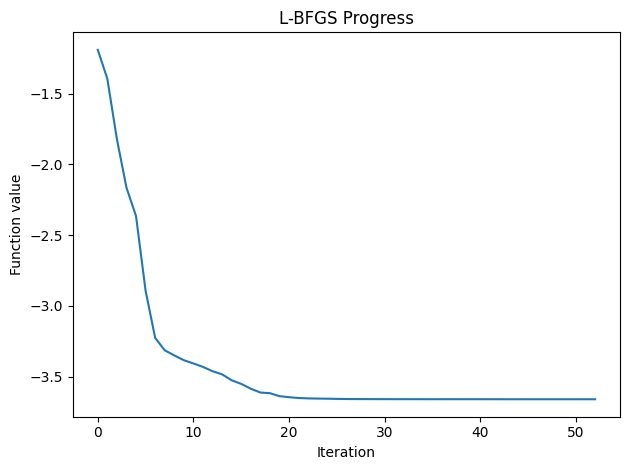

In [11]:
plt.plot(fhist)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('L-BFGS Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [12]:
#Optimizing using Adam algorithm
def adam_optimize(func, grad, theta_init, alpha=0.3, beta1=0.9, beta2=0.999,epsilon=1e-8, max_iters=500, tolerance=1e-6):
    theta = theta_init.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)

    thetas = [theta.copy()]
    losses = [func(theta)]
    f_history = []
    for t in range(1, max_iters + 1):
        g = grad_numerical(func, theta)

        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        f_val = func(theta)
        thetas.append(theta.copy())
        losses.append(f_val)
        f_history.append(f_val)
        # Early stopping based on function change
        if abs(losses[-1] - losses[-2]) < tolerance:
                #print(f"[Adam] Early stopping at iteration {t}: Δf = {abs(losses[-1] - losses[-2]):.2e} < {tolerance}")
                break

    return theta, losses, thetas, f_history


In [13]:

theta_init = np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)  # Initial guess for θ
soladam, loss_history, theta_path,fhistory = adam_optimize(cost, lambda x: grad_numerical(cost, x), theta_init)
print(f"[Adam] Optimal θ: {soladam}")
print(f"[Adam] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: {loss_history[-1]:.6f}") 
print(f"[Adam] Iterations: {len(loss_history)}")
print(fhistory)

[Adam] Optimal θ: [ 3.22256672e+00 -6.33762833e+00  1.54222172e+00  4.76996533e+00
 -3.24587307e-01  4.87938712e+00  1.59760100e+00  3.10291224e+00
 -4.24234651e-03  1.55373904e+00  6.36231193e+00  1.56945959e+00
  4.73923655e+00  4.72388710e+00  6.10000008e+00  1.40691922e+00
  3.14090694e+00  1.56800829e+00  6.29066017e+00  3.11094305e+00
  3.14160375e+00  4.71111745e+00  3.19680473e+00  4.75830280e+00
 -4.99234158e-01  3.12736152e+00  1.57630100e+00  4.71759371e+00
  6.28154973e+00  4.70579838e+00]
[Adam] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -3.124781
[Adam] Iterations: 80
[-1.1706144185346912, -1.4991645997011818, -1.7417944622631485, -2.233466549732638, -2.6459692523552807, -2.8031813711095985, -2.8320522297378483, -2.766992685901682, -2.6984099457326516, -2.7127372155169858, -2.7994296850331035, -2.894616203504959, -2.9590533852626084, -3.0045565522629345, -3.0427919688674185, -3.048588614428247, -3.020143593040552, -2.986730683564614, -2.9690136739355064, -2.9698943011575665, -2.9876619

In [35]:
soladam=[ 3.22256672e+00 ,-6.33762833e+00,  1.54222172e+00 , 4.76996533e+00,
 -3.24587307e-01 , 4.87938712e+00,  1.59760100e+00 , 3.10291224e+00,
 -4.24234651e-03 , 1.55373904e+00,  6.36231193e+00 , 1.56945959e+00,
  4.73923655e+00 , 4.72388710e+00 , 6.10000008e+00 , 1.40691922e+00,
  3.14090694e+00 , 1.56800829e+00 , 6.29066017e+00 , 3.11094305e+00,
  3.14160375e+00 , 4.71111745e+00 , 3.19680473e+00 , 4.75830280e+00,
 -4.99234158e-01 , 3.12736152e+00  ,1.57630100e+00  ,4.71759371e+00,
  6.28154973e+00 , 4.70579838e+00]

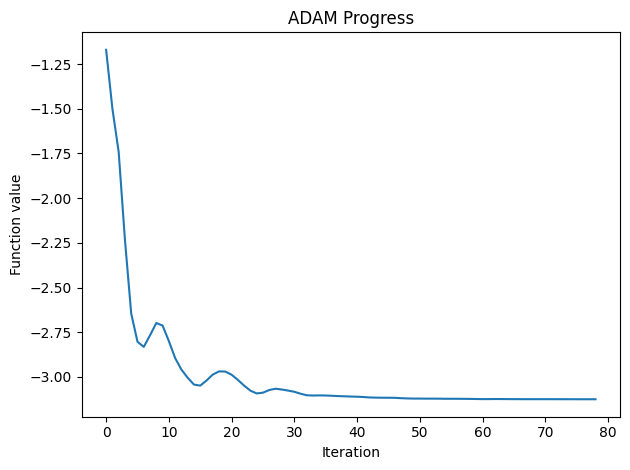

In [15]:
plt.plot(fhistory)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('ADAM Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

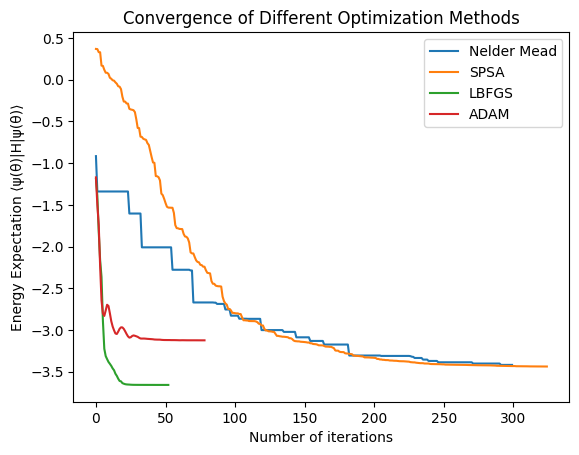

In [42]:
import matplotlib.pyplot as plt

y1 = fhisto
y2 = f_history
y3 = fhist
y4 = fhistory

# Generate corresponding x-values automatically
x1 = list(range(len(y1)))
x2 = list(range(len(y2)))
x3 = list(range(len(y3)))
x4 = list(range(len(y4)))

# Plot each with its own x
plt.plot(x1, y1, label='Nelder Mead')
plt.plot(x2, y2, label='SPSA')
plt.plot(x3, y3, label='LBFGS')
plt.plot(x4, y4, label='ADAM')

plt.xlabel('Number of iterations')
plt.ylabel('Energy Expectation ⟨ψ(θ)|H|ψ(θ)⟩')
plt.title('Convergence of Different Optimization Methods')
plt.legend()
plt.grid(False)
plt.show()



In [81]:
def sample_bitstrings(statevector, n_samples):
    probs = np.abs(statevector) ** 2
    assert np.isclose(np.sum(probs), 1.0), "Probabilities must sum to 1"
    outcomes = np.random.choice(len(probs), size=n_samples, p=probs) 
    bitstrings = [format(i, f'0{n_qubits}b') for i in outcomes]
    return bitstrings
theta = solspsa  # example parameters
state = ansatz(theta, n_qubits, edges, n_layers)
bitstrings = sample_bitstrings(state , 1000)
print(bitstrings)
print("Sampled bitstrings:", len(bitstrings))

['1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110010', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110010', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000

In [82]:
def hamiltonian(n_qubits, seed):
    np.random.seed(seed)
    # Build symbolic Hamiltonian: (weight, [i, j]) for ZZ terms
    weights2 = [round(x, 3) for x in weights]
    hamiltonian_terms = [(weights[k], [i, j]) for k, (i, j) in enumerate(edges)]
    return hamiltonian_terms
hamiltonian_terms=hamiltonian(n_qubits, seed) 

In [83]:
def estimate_expectation(bitstrings, hamiltonian_terms):
    total = 0
    for bitstring in bitstrings:
        val = 0
        for coeff, qubits in hamiltonian_terms:
            product = 1
            for q in qubits:
                product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
            val += coeff * product
        total += val
    return total / len(bitstrings)
expect_val = estimate_expectation(bitstrings, hamiltonian_terms)
print("Estimated ⟨H⟩ =", expect_val)
def bitstring_energy(bitstring, hamiltonian_terms):
    val = 0
    for coeff, qubits in hamiltonian_terms:
        product = 1
        for q in qubits:
            product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
        val += coeff * product
    return val

Estimated ⟨H⟩ = -3.437141163955006


In [84]:
from collections import Counter
bitstring_counts = Counter(bitstrings)
bitstring_data = []
for bitstring, count in bitstring_counts.items():
    energy = bitstring_energy(bitstring, hamiltonian_terms)
    bitstring_data.append((bitstring, count, energy))
print(bitstring_data)

[('1000110100', 954, -3.4566089876880817), ('1000110010', 31, -3.1617489278669364), ('1000010101', 11, -2.9869086530862425), ('1000101110', 1, 0.14564407378865452), ('1101110000', 1, -3.638809920630472), ('1001110100', 2, -2.5864059529751695)]


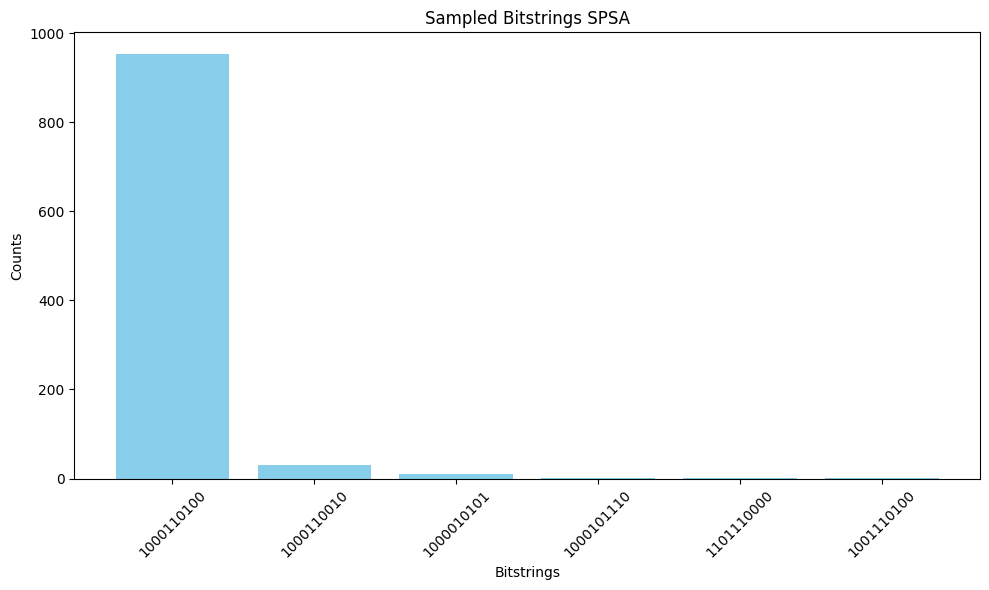

In [85]:
bitstrings_unique = list(bitstring_counts.keys())
frequencies = list(bitstring_counts.values())
plt.figure(figsize=(10,6))
plt.bar(bitstrings_unique, frequencies, color='skyblue')
plt.xlabel('Bitstrings')
plt.ylabel('Counts')
plt.title('Sampled Bitstrings SPSA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
